<a href="https://colab.research.google.com/github/Dannyhamtar/MachineLearning/blob/main/Task%20week%2012/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Nama       : Mochamad Permana Ash Shidiq
* NIM        : 1103228233
* Model      : ResNet

##Import modul

In [ ]:
!pip install d2l

In [ ]:
import torch
# library utama untuk komputasi tensor dan pembelajaran mendalam (deep learning) menggunakan PyTorch. Library ini menyediakan berbagai fungsi untuk operasi matematika dan manipulasi tensor.
from torch import nn
# digunakan untuk membangun dan melatih jaringan saraf, seperti lapisan jaringan saraf (layers), fungsi aktivasi, dan fungsi kerugian (loss functions).
import d2l.torch as d2l
# menyediakan berbagai fungsi dan utilitas yang membantu dalam pembelajaran mendalam menggunakan PyTorch. Modul ini mencakup fungsi untuk visualisasi, pemrosesan data, dan banyak lagi.
from torch.nn import functional as F
# berisi berbagai fungsi yang digunakan dalam membangun dan menjalankan jaringan saraf (neural networks). Fungsi-fungsi ini mencakup berbagai operasi yang sering digunakan dalam deep learning, seperti aktivasi, kehilangan (loss), dan operasi konvolusi.


##Residual Blocks

In [ ]:
class Residual(nn.Module):
  # Mendefinisikan kelas Residual yang merupakan subclass dari nn.Module
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
      # Inisialisasi kelas dengan parameter jumlah channel, penggunaan konvolusi 1x1, dan langkah (stride)
        super().__init__()
        # Memanggil konstruktor dari nn.Module

        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        # Definisi konvolusi pertama dengan kernel 3x3, padding 1, dan langkah sesuai parameter

        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
          # Definisi konvolusi kedua dengan kernel 3x3 dan padding 1

            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            #  Definisi konvolusi ketiga dengan kernel 1x1 dan langkah sesuai parameter

        else:
          # Jika penggunaan konvolusi 1x1 tidak diaktifkan
            self.conv3 = None
            # Konvolusi ketiga tidak digunakan
        self.bn1 = nn.LazyBatchNorm2d()
        # Definisi batch normalization pertama
        self.bn2 = nn.LazyBatchNorm2d()
        # Definisi batch normalization kedua

    def forward(self, X):
      # Definisi metode forward untuk menjalankan data melalui lapisan-lapisan jaringan
        Y = F.relu(self.bn1(self.conv1(X)))
        # Proses input X melalui konvolusi pertama, batch normalization, dan fungsi aktivasi ReLU
        Y = self.bn2(self.conv2(Y))
        # Proses hasil Y melalui konvolusi kedua dan batch normalization
        if self.conv3:
          # Jika konvolusi ketiga digunakan
            X = self.conv3(X)
            # Proses input X melalui konvolusi ketiga
        Y += X
        # Tambahkan input asli X ke hasil Y
        return F.relu(Y)
        # Kembalikan hasil dengan fungsi aktivasi ReLU

In [ ]:
blk = Residual(3)
 # Membuat instance dari blok residu dengan input channel sebanyak 3
X = torch.randn(4, 3, 6, 6)
# Membuat tensor acak dengan bentuk (batch_size=4, channels=3, height=6, width=6)
blk(X).shape
# Mendapatkan bentuk keluaran dari tensor setelah melewati blok residu

torch.Size([4, 3, 6, 6])

In [ ]:
torch.Size([4, 3, 6, 6])
# Mendefinisikan ukuran tensor di PyTorch

torch.Size([4, 3, 6, 6])

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
# Membuat instance dari blok residual dengan parameter input 6, menggunakan konvolusi 1x1 untuk menyesuaikan dimensi, dan strides 2
blk(X).shape
# Memanggil blok residual blk dengan input X dan mendapatkan bentuk (shape) dari outputnya

torch.Size([4, 6, 3, 3])

##ResNet Model

In [ ]:
class ResNet(d2l.Classifier):
  # Mendefinisikan kelas ResNet yang merupakan subclass dari d2l.Classifier
    def b1(self):
      # Mendefinisikan metode b1 dalam kelas ResNet
        return nn.Sequential(
            # Mengembalikan urutan layer-layer menggunakan nn.Sequential
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            # Layer konvolusi dengan 64 filter, ukuran kernel 7x7, stride 2, dan padding 3
            nn.LazyBatchNorm2d(), nn.ReLU(),
            # Layer Batch Normalization yang menyesuaikan ukuran secara otomatis
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
             # Layer MaxPooling dengan ukuran kernel 3x3, stride 2, dan padding 1


In [ ]:
@d2l.add_to_class(ResNet)
# Menambahkan metode baru dalam kelas ResNet dari modul d2l
def block(self, num_residuals, num_channels, first_block=False):
  # Mendefinisikan metode block dalam kelas ResNet
    blk = []
    # Inisialisasi list kosong untuk menyimpan blok residual
    for i in range(num_residuals):
      # Looping sebanyak num_residuals kali
        if i == 0 and not first_block:
          # Jika iterasi pertama dan bukan blok pertama
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            # Tambahkan blok residual dengan konvolusi 1x1 dan strides 2
        else:
          # Jika bukan iterasi pertama atau merupakan blok pertama
            blk.append(Residual(num_channels))
            # Tambahkan blok residual tanpa konvolusi 1x1
    return nn.Sequential(*blk)
    # Mengembalikan urutan blok residual menggunakan nn.Sequential

In [ ]:
@d2l.add_to_class(ResNet)
# fungsi sebagai metode konstruktor untuk ResNetkelas
def __init__(self, arch, lr=0.1, num_classes=10):
  # mendefinisikan metode konstruktor ( __init__) untuk ResNetkelas
    super(ResNet, self).__init__()
    # memanggil konstruktor kelas induk ( super), yang kemungkinan merupakan nn.Modulekelas di sebagian besar perpustakaan pembelajaran mendalam.
    self.save_hyperparameters()
    # menyimpan hyperparameter (kecepatan pembelajaran dan jumlah kelas) yang diteruskan ke konstruktor untuk digunakan nanti.
    self.net = nn.Sequential(self.b1())
    #  membuat wadah berurutan (nn.Sequential) untuk menampung lapisan model ResNet
    for i, b in enumerate(arch):
      # Perulangan ini mengulangiarchlist (arsitektur model) untuk membuat dan menambahkan sisa blok yang tersisa keself.netwadah berurutan.
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        # menambahkan modul baru keself.netwadah.
    self.net.add_module('last', nn.Sequential(
        # Setelah menambahkan blok sisa,baris ini menambahkan wadah berurutan terakhir yang diberi nama"last"keself.netwadah.Urutan ini mendefinisikan lapisan keluaran model
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
class ResNet18(ResNet):
  # mendefinisikan nama kelas baru ResNet18yang mewarisi dari ResNetkelas tersebut.
    def __init__(self, lr=0.1, num_classes=10):
      # mendefinisikan konstruktor (metode inisialisasi) untuk ResNet18kelas. Dibutuhkan dua argumen
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
         # Baris ini memanggil __init__metode kelas induk ( ResNet) untuk menginisialisasi ResNet18objek. Ini melewati tiga argumen
                       lr, num_classes)
                        # umlah kelas keluaran yang diteruskan dari konstruktor.

ResNet18().layer_summary((1, 1, 96, 96))
# Metode ini diasumsikan mencetak ringkasan lapisan model, termasuk namanya, bentuk masukan dan keluaran, serta jumlah parameter.

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


##Training

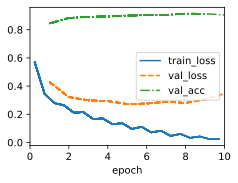

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)